In [2]:
# credit_card_fraud_smote_rf_fast.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import warnings
warnings.filterwarnings("ignore")

mkdir -p failed for path C:\Users\prasa\.matplotlib: [WinError 5] Access is denied: 'C:\\Users\\prasa\\.matplotlib'
Matplotlib created a temporary cache directory at C:\Users\prasa\AppData\Local\Temp\matplotlib-0emm6g40 because there was an issue with the default path (C:\Users\prasa\.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:

# ---------- USER CONFIG ----------
DATA_PATH = "creditcard_2023.csv"   # <-- change this
TARGET = "Class"                         # <-- change to your target column name
RANDOM_STATE = 42
TEST_SIZE = 0.2
APPLY_SMOTE_IF_RATIO = 0.5   # if minority/majority < this value, apply SMOTE
# ---------------------------------

# Load dataset
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)


Dataset shape: (568630, 31)


In [4]:

# Split features/target
y = df[TARGET]
X = df.drop(columns=[TARGET])

# Check imbalance ratio
minority_count = y.value_counts().min()
majority_count = y.value_counts().max()
imbalance_ratio = minority_count / majority_count
print("\nTarget distribution:")
print(y.value_counts())
print(f"Imbalance ratio (minority/majority) = {imbalance_ratio:.4f}")



Target distribution:
Class
0    284315
1    284315
Name: count, dtype: int64
Imbalance ratio (minority/majority) = 1.0000


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

print("\nTrain set distribution:", Counter(y_train))
print("Test set distribution:", Counter(y_test))



Train set distribution: Counter({0: 227452, 1: 227452})
Test set distribution: Counter({1: 56863, 0: 56863})


In [6]:
# Standardize numeric features
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols]  = scaler.transform(X_test[numeric_cols])


In [7]:
# Apply SMOTE if needed
if imbalance_ratio < APPLY_SMOTE_IF_RATIO:
    print(f"\nApplying SMOTE (ratio {imbalance_ratio:.4f} < {APPLY_SMOTE_IF_RATIO})...")
    sm = SMOTE(random_state=RANDOM_STATE)
    X_res, y_res = sm.fit_resample(X_train_scaled, y_train)
    print("Resampled train distribution:", Counter(y_res))
else:
    print("\nSkipping SMOTE.")
    X_res, y_res = X_train_scaled, y_train



Skipping SMOTE.


In [8]:
# Train RandomForest (fixed params for speed)
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=2,          # much shallower trees
    min_samples_split=5, # prevents overfitting
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)


rf.fit(X_res, y_res)

# Evaluate
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]



Classification Report:
              precision    recall  f1-score   support

           0     0.9203    0.9991    0.9581     56863
           1     0.9990    0.9135    0.9543     56863

    accuracy                         0.9563    113726
   macro avg     0.9597    0.9563    0.9562    113726
weighted avg     0.9597    0.9563    0.9562    113726



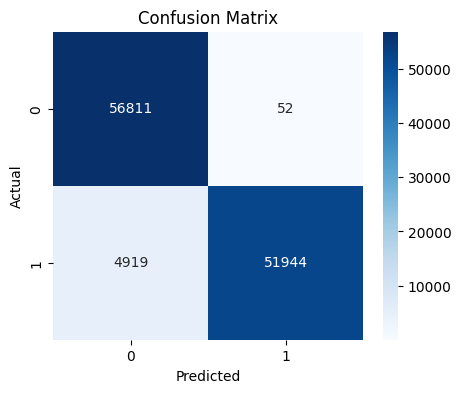

ROC AUC: 0.9996
Average Precision (PR AUC): 0.9996


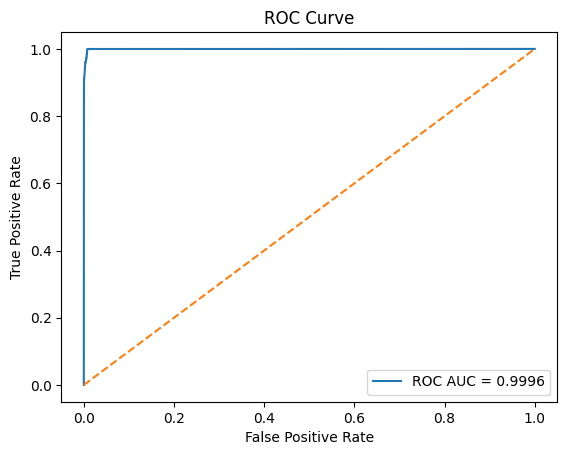

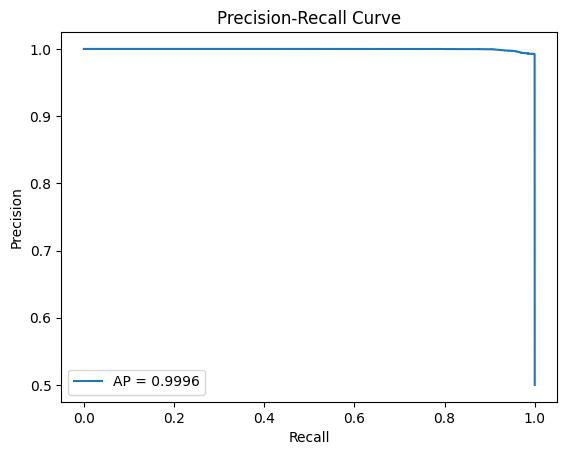

In [9]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC and PR curves
roc_auc = roc_auc_score(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision (PR AUC): {avg_precision:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()



In [10]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9563


In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[56811    52]
 [ 4919 51944]]


In [12]:
# Save model + scaler
joblib.dump(rf, "rf_fraud_model_fast.joblib")
joblib.dump(scaler, "scaler_fast.joblib")
print("\n✅ Model and scaler saved as 'rf_fraud_model_fast.joblib' and 'scaler_fast.joblib'")



✅ Model and scaler saved as 'rf_fraud_model_fast.joblib' and 'scaler_fast.joblib'
